Stocks Rag

Author: Orvin Bellamy (https://github.com/orvinbellamy)

In [56]:
## Import libraries

import yfinance as yf
import pandas as pd
import openai
from openai import OpenAI
import os
import json
import fs
import time
from dotenv import load_dotenv
import logging as log
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from filehandler import FileHandler
from yfinancehandler import YFHandler
from eventhandler import EventHandler, ThreadManager
from agenthandler import AgentHandler

In [ ]:
def check_run_status(client, thread_id: str, run_id: str, n_tries: int, wait_time):
    
    ## Wait until status is completed
    for i in range(0, n_tries):

        # Retrieve the latest run
        run_retrieve = client.beta.threads.runs.retrieve(
            thread_id=thread_id,
            run_id=run_id
        )

        # Get the run status
        run_status = run_retrieve.status

        # Check run status
        if run_status == 'completed':
            print('Run is completed')
            return f'Run is completed (run_id: {run_id}, thread_id {thread_id})'
        elif run_status == 'in_progress':
            print('Run is in progress')
            pass
        elif run_status == 'queued':
            print('Run is queued')
            pass
        elif run_status == 'cancelling':
            print('Run is cancelling')
            pass
        elif run_status == 'cancelled':
            raise ValueError(f'Error: run is cancelled (run_id: {run_id}, thread_id {thread_id})')
        elif run_status == 'failed':
            raise ValueError(f'Error: run has failed (run_id: {run_id}, thread_id {thread_id})')
        elif run_status == 'expired':
            raise ValueError(f'Error: run has expired (run_id: {run_id}, thread_id {thread_id})')
        elif run_status == 'requires_action':
            print('Action is required')
            return f'Action required (run_id: {run_id}, thread_id {thread_id})'

        # Sleep to give time for the run to process
        time.sleep(wait_time)

In [3]:
## configruation

FILE_PATH = 'openai_upload_files/'
OPENAI_DIC_FILE_NAME = 'openai_files.json'

# Set constants for loops
NUM_TRIES = 12
TIME_SLEEP = 5 # in seconds

# load_dotenv('config.env')
# OPEN_API_KEY = os.getenv('OPEN_API_KEY')

# List of JSON files
# json_files = [('income_stmt', 'df_income_stmt_columns.json'), ('cashflow', 'df_cashflow_columns.json'), ('stocks', 'df_stocks_columns.json')]

# Load schemas from JSON file
with open('dataframe_schemas.json', 'r') as f:
    schemas = json.load(f)

with open('config/config.json', 'r') as f:
    dic_config = json.load(f)
    OPEN_API_KEY = dic_config['OPEN_API_KEY']
    FIN_ANALYST_ID = dic_config['fin_analyst_assistant']

# Initialize an empty list to store the stocks
stocks_list = []

# Open the text file in read mode
with open('stocks.txt', 'r') as file:
    # Read each line of the file
    for line in file:
        # Strip any leading or trailing whitespace and append the line to the list
        stocks_list.append(line.strip())

df_portfolio = pd.read_csv('config/portfolio.csv')

list_portfolio = list(df_portfolio['ticker'].unique())

# Open dic_files
with open(f'{FILE_PATH}{OPENAI_DIC_FILE_NAME}', 'r') as f:
    dic_files = json.load(f)

client = OpenAI(api_key=OPEN_API_KEY)

### Stocks Data

In [ ]:
stocks_list = ['MSFT', 'SHOP', 'AMD', 'NVDA', 'AAPL', 'OKTA', 'SHOP', 'AMAT', 'TTWO', 'SNOW', 'SOXX', 'BA', 'DOCN', 'MCD', 'LULU', 'CSCO', 'ORCL', 'AMZN', 'ASML']

yf_handler = YFHandler(stock_list=stocks_list, schemas=schemas)

df_stocks = yf_handler.import_stocks()
df_cashflow = yf_handler.import_cashflow()
df_income_stmt = yf_handler.import_income_stmt()

# Write to CSV
# Technically this will be done by the FileHandler but just to be safe
df_stocks.to_csv('openai_upload_files/df_stocks.csv', index=False)
df_cashflow.to_csv('openai_upload_files/df_cashflow.csv', index=False)
df_income_stmt.to_csv('openai_upload_files/df_income_stmt.csv', index=False)

file_stocks = FileHandler(
    df=df_stocks,
    dic_file=dic_files,
    file_name='df_stocks.csv',
    file_path=FILE_PATH,
    client=client
)

file_cashflow = FileHandler(
    df=df_cashflow,
    dic_file=dic_files,
    file_name='df_cashflow.csv',
    file_path=FILE_PATH,
    client=client
)

file_income_stmt = FileHandler(
    df=df_income_stmt,
    dic_file=dic_files,
    file_name='df_income_stmt.csv',
    file_path=FILE_PATH,
    client=client
)

In [ ]:
# Update files
file_stocks.update_openai_file(dic_file=dic_files, dic_file_name=OPENAI_DIC_FILE_NAME, dic_file_path=FILE_PATH)
file_cashflow.update_openai_file(dic_file=dic_files, dic_file_name=OPENAI_DIC_FILE_NAME, dic_file_path=FILE_PATH)
file_income_stmt.update_openai_file(dic_file=dic_files, dic_file_name=OPENAI_DIC_FILE_NAME, dic_file_path=FILE_PATH)

In [4]:
with open('config/assistants.json', 'r') as json_file:
    dic_assistants= json.load(json_file)

# Have to manually update the tool_resources because the file_id can change
dic_assistants['fin_analyst']['tool_resources'] = {
    'code_interpreter': {'file_ids': [dic_files['df_stocks.csv']]}
}

with open('config/assistants.json', 'w') as json_file:
    json.dump(dic_assistants, json_file)
    print(f'assistants.json file has been updated')

fin_analyst = AgentHandler(
    client = client, 
    assistant_name = 'fin_analyst',
    dic_agent = dic_assistants
    )

assistants.json file has been updated


In [5]:
## Create thread
thread = ThreadManager(
    client=client,
    messages=[
        {
            'role': 'user',
            'content': 'Can you explain to me what the file I have attached is.',
            'attachments': [
                {
                    'file_id': 'file-G8Scw9sLUsW5L6oyEAGb3O30',
                    'tools': [{'type': 'code_interpreter'}]
                }
            ]
        }
    ]
)


In [9]:
prompt = [
	{
		'role': 'user',
		'content': 'Can you make a graph of the stock price for me.',
		'attachments': [
			{
				'file_id': 'file-G8Scw9sLUsW5L6oyEAGb3O30',
                'tools': [{'type': 'code_interpreter'}]
			}
		]
	}
]

thread.run_thread(assistant=fin_analyst, message=prompt)


assistant > code_interpreter

import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format
file_content['Date'] = pd.to_datetime(file_content['Date'])

# Plotting the 'Close' price
plt.figure(figsize=(14, 7))
plt.plot(file_content['Date'], file_content['Close'], label='Close Price')
plt.title('Microsoft (MSFT) Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

output >

assistant > The graph above displays the closing price of Microsoft (MSFT) stock over time. This visual representation helps to observe the stock's performance, trends, and fluctuations from the initial date in the dataset to the most recent date.

The sharp increase in the stock price, particularly in the recent years, indicates significant growth. If you need a more detailed analysis or want to focus on a specific time period, please let me know!

AttributeError: 'ImageFileContentBlock' object has no attribute 'text'

In [79]:
# thread.thread_id
# messages = client.beta.threads.messages.list(thread_id=thread.thread_id).data
# messages[0].content[0].image_file.file_id
# file_id = 'file-ZGJobD95f0QsOKv03l2dTtUW'
# file = client.files.content(file_id)
thread.dic_thread

{'msg_gQaBV1pTNanRilFe1bT0EcQa': {'assistant_id': None,
  'created_at': 1722923855,
  'file_ids': [Attachment(file_id='file-G8Scw9sLUsW5L6oyEAGb3O30', tools=[CodeInterpreterTool(type='code_interpreter')])],
  'role': 'user',
  'run_id': None,
  'message_text': 'Can you explain to me what the file I have attached is.'},
 'msg_ismTg7aO5zU6Cq0F61K2rMdc': {'assistant_id': 'asst_Mqf9cO1sDTOd4UMYwcFfIQrA',
  'created_at': 1722923910,
  'file_ids': [],
  'role': 'assistant',
  'run_id': 'run_hiwFbXRC4ZqDf0l30tUCnkLa',
  'message_text': "The file you have uploaded is a CSV file containing historical stock market data for Microsoft Corporation (MSFT). It includes the following columns:\n\n1. **Date**: The date of the trading day.\n2. **Open**: The opening price of the stock on that day.\n3. **High**: The highest price the stock reached on that day.\n4. **Low**: The lowest price the stock reached on that day.\n5. **Close**: The closing price of the stock on that day.\n6. **Volume**: The number o

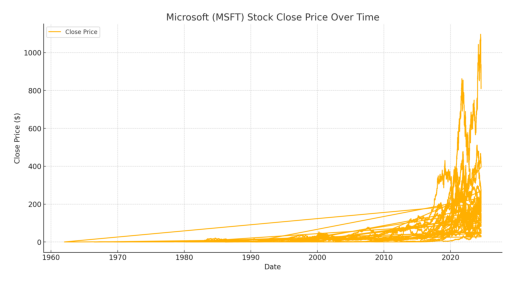

In [60]:
# file.write_to_file('test.png')
type(file)
image = mpimg.imread("test.png")
plt.imshow(image)
plt.axis('off')
plt.show()

In [80]:
# test = []
test = test + ['test5']
test == []

False

In [ ]:
# Set ThreadManager to easily track messages in a single thread
# thread
# with client.beta.threads.runs.stream(
#     thread_id=thread.id,
#     assistant_id=FIN_ANALYST_ID,
#     event_handler=EventHandler(),
#     additional_messages= [
#         {
#             'role': 'user',
#             'content': 'Can you give an assessment on how the stock is doing?',
#             'attachments': [
#                 {
#                     'file_id': file_stocks.file_id,
#                     'tools': [{'type': 'code_interpreter'}]
#                 }
#             ]
#         }
#     ]
# ) as stream:
#     stream.until_done()

# thread_fin_analyst.get_last_message()

# list_thread = client.beta.threads.messages.list(thread_id=thread_id).data
list_thread[0].content

# client.beta.threads.delete(thread_id=thread_id)